In [1]:
from src.dataset_lasot import DatasetLaSOT
from src.model import SiameseTrackerDino
from src.loss import compute_loss
from src.draw_samples_training import draw_samples_training
import config.config as cfg

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import datetime
import json
import sys
import copy
import os

%matplotlib inline

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

################ LOAD ALL THE PARAMETERS #############################
# DATASET PARAMETERS
DIR_DATA = cfg.DIR_DATA # Root to the folder with the prepared data
SIZE_TEMPLATE = cfg.SIZE_TEMPLATE
SIZE_SEARCH = cfg.SIZE_SEARCH
SIZE_OUT = cfg.SIZE_OUT
MAX_FRAME_SEP = cfg.MAX_FRAME_SEP
NEG_PROB = cfg.NEG_PROB
EXTRA_CONTEXT_TEMPLATE = cfg.EXTRA_CONTEXT_TEMPLATE
MIN_EXTRA_CONTEXT_SEARCH = cfg.MIN_EXTRA_CONTEXT_SEARCH
MAX_EXTRA_CONTEXT_SEARCH = cfg.MAX_EXTRA_CONTEXT_SEARCH
MAX_SHIFT = cfg.MAX_SHIFT
REG_FULL = cfg.REG_FULL
IMG_AUGMENT_TRAINING = cfg.IMG_AUGMENT_TRAINING
IMG_AUGMENT_VALID = cfg.IMG_AUGMENT_VALID
IMG_MEAN = cfg.IMG_MEAN
IMG_STD = cfg.IMG_STD
    
# MODEL PARAMETERS
DINOV3_DIR = cfg.DINOV3_DIR
DINO_MODEL = cfg.DINO_MODEL
BATCH_SIZE = cfg.BATCH_SIZE
PROJ_DIM = cfg.PROJ_DIM
MODEL_TO_NUM_LAYERS = cfg.MODEL_TO_NUM_LAYERS

# TRAINING PARAMETERS
THRESHOLD_CLS = cfg.THRESHOLD_CLS
ALPHA_LOSS = cfg.ALPHA_LOSS
GAMMA_LOSS = cfg.GAMMA_LOSS 
WEIGHT_LOSS = cfg.WEIGHT_LOSS

LEARNING_RATE = cfg.LEARNING_RATE
NUM_EPOCHS = cfg.NUM_EPOCHS
NUM_SAMPLES_PLOT = cfg.NUM_SAMPLES_PLOT

LOAD_MODEL = cfg.LOAD_MODEL
SAVE_MODEL = cfg.SAVE_MODEL
MODEL_PATH_TRAIN_LOAD = cfg.MODEL_PATH_TRAIN_LOAD
RESULTS_PATH = cfg.RESULTS_PATH

train_set = DatasetLaSOT("train", DIR_DATA, SIZE_TEMPLATE, SIZE_SEARCH, SIZE_OUT, MAX_FRAME_SEP, 
                                 NEG_PROB, EXTRA_CONTEXT_TEMPLATE, MIN_EXTRA_CONTEXT_SEARCH, MAX_EXTRA_CONTEXT_SEARCH, MAX_SHIFT, REG_FULL,
                                IMG_AUGMENT_TRAINING, IMG_MEAN, IMG_STD)
train_dataloader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)

val_set = DatasetLaSOT("val", DIR_DATA, SIZE_TEMPLATE, SIZE_SEARCH, SIZE_OUT, MAX_FRAME_SEP, 
                                 NEG_PROB, EXTRA_CONTEXT_TEMPLATE, MIN_EXTRA_CONTEXT_SEARCH, MAX_EXTRA_CONTEXT_SEARCH, MAX_SHIFT, REG_FULL,
                                  IMG_AUGMENT_VALID, IMG_MEAN, IMG_STD)
val_dataloader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle=True)

dino_model = torch.hub.load(
        repo_or_dir=DINOV3_DIR,
        model="dinov3_vits16plus",
        source="local"
    )
n_layers_dino = MODEL_TO_NUM_LAYERS[DINO_MODEL]
model = SiameseTrackerDino(dino_model = dino_model, n_layers_dino = n_layers_dino, out_size = SIZE_OUT, 
                            proj_dim = PROJ_DIM, reg_full = REG_FULL).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Load model
if LOAD_MODEL:
    model.load_state_dict(torch.load(MODEL_PATH_TRAIN_LOAD))
    print("Model successfully loaded!")

# Freeze parameters
for p in model.backbone.parameters():
    p.requires_grad = False

n_params = sum([p.numel() for p in model.parameters()])
print("Total number of parameters: ", n_params)
n_trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Total number of trainable parameters: ", n_trainable_params)
n_params_backbone = sum([p.numel() for p in model.backbone.parameters()])
print("Number parameters backbone: ", n_params_backbone)

if SAVE_MODEL:
    current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    folder_path = f"{RESULTS_PATH}/{current_date}"
    
    json_params = { 
        "SIZE_TEMPLATE" : SIZE_TEMPLATE, 
        "SIZE_SEARCH" : SIZE_SEARCH, 
        "SIZE_OUT" : SIZE_OUT, 
        "MAX_FRAME_SEPT" : MAX_FRAME_SEP,
        "NEG_PROB" : NEG_PROB,
        "EXTRA_CONTEXT_TEMPLATE" : EXTRA_CONTEXT_TEMPLATE,
        "MIN_EXTRA_CONTEXT_SEARCH" : MIN_EXTRA_CONTEXT_SEARCH,
        "MAX_EXTRA_CONTEXT_SEARCH " : MAX_EXTRA_CONTEXT_SEARCH,
        "MAX_SHIFT" : MAX_SHIFT,
        "REG_FULL" : REG_FULL,
        "IMG_AUGMENT_TRAINING": IMG_AUGMENT_TRAINING,
        "IMG_AUGMENT_VALID": IMG_AUGMENT_VALID,
        "THRESHOLD_CLS" : THRESHOLD_CLS,
        "ALPHA_LOSS" : ALPHA_LOSS,
        "GAMMA_LOSS" : GAMMA_LOSS,
        "WEIGHT_LOSS" : WEIGHT_LOSS,
        "LEARNING_RATE" : LEARNING_RATE,
        "LOAD_MODEL" : LOAD_MODEL,
        "MODEL_PATH_TRAIN_LOAD" : MODEL_PATH_TRAIN_LOAD,
        "DINO_MODEL": DINO_MODEL,
        "PROJ_DIM": PROJ_DIM
    }

Using device:  cuda
Total number of parameters:  29026179
Total number of trainable parameters:  328707
Number parameters backbone:  28697472


  1%|█▊                                                                                                                                           | 1001/79025 [04:24<5:37:40,  3.85it/s]

Epoch 1, batch 1000, Loss: 1.6945847615852698, cls loss: 0.23391452431678772, regression loss: 1.203312873840332


  3%|███▌                                                                                                                                         | 2001/79025 [08:43<5:44:12,  3.73it/s]

Epoch 1, batch 2000, Loss: 1.4632658105025227, cls loss: 0.33729347586631775, regression loss: 0.8445892930030823


  4%|█████▎                                                                                                                                       | 3001/79025 [13:07<5:34:28,  3.79it/s]

Epoch 1, batch 3000, Loss: 1.3409159472687011, cls loss: 0.23536962270736694, regression loss: 0.9115448594093323


  5%|███████▏                                                                                                                                     | 4001/79025 [17:27<5:28:13,  3.81it/s]

Epoch 1, batch 4000, Loss: 1.2524645273252237, cls loss: 0.18026849627494812, regression loss: 0.8308917880058289


  6%|████████▉                                                                                                                                    | 5001/79025 [21:46<5:19:07,  3.87it/s]

Epoch 1, batch 5000, Loss: 1.1782812225034394, cls loss: 0.16144752502441406, regression loss: 0.6504943370819092


  8%|██████████▋                                                                                                                                  | 6001/79025 [26:02<5:09:42,  3.93it/s]

Epoch 1, batch 6000, Loss: 1.1118079366494846, cls loss: 0.18167603015899658, regression loss: 0.6234912276268005


  9%|████████████▍                                                                                                                                | 7001/79025 [30:26<5:16:43,  3.79it/s]

Epoch 1, batch 7000, Loss: 1.0502126107231546, cls loss: 0.1335345208644867, regression loss: 0.4924124479293823


 10%|██████████████▎                                                                                                                              | 8001/79025 [34:51<5:20:03,  3.70it/s]

Epoch 1, batch 8000, Loss: 0.993502698925313, cls loss: 0.12533511221408844, regression loss: 0.44266507029533386


 11%|████████████████                                                                                                                             | 9001/79025 [39:15<5:06:41,  3.81it/s]

Epoch 1, batch 9000, Loss: 0.9421927204775474, cls loss: 0.1288079023361206, regression loss: 0.3281795382499695


 13%|█████████████████▋                                                                                                                          | 10000/79025 [43:48<5:21:33,  3.58it/s]

Epoch 1, batch 10000, Loss: 0.8955742579593073, cls loss: 0.1278449296951294, regression loss: 0.27870842814445496


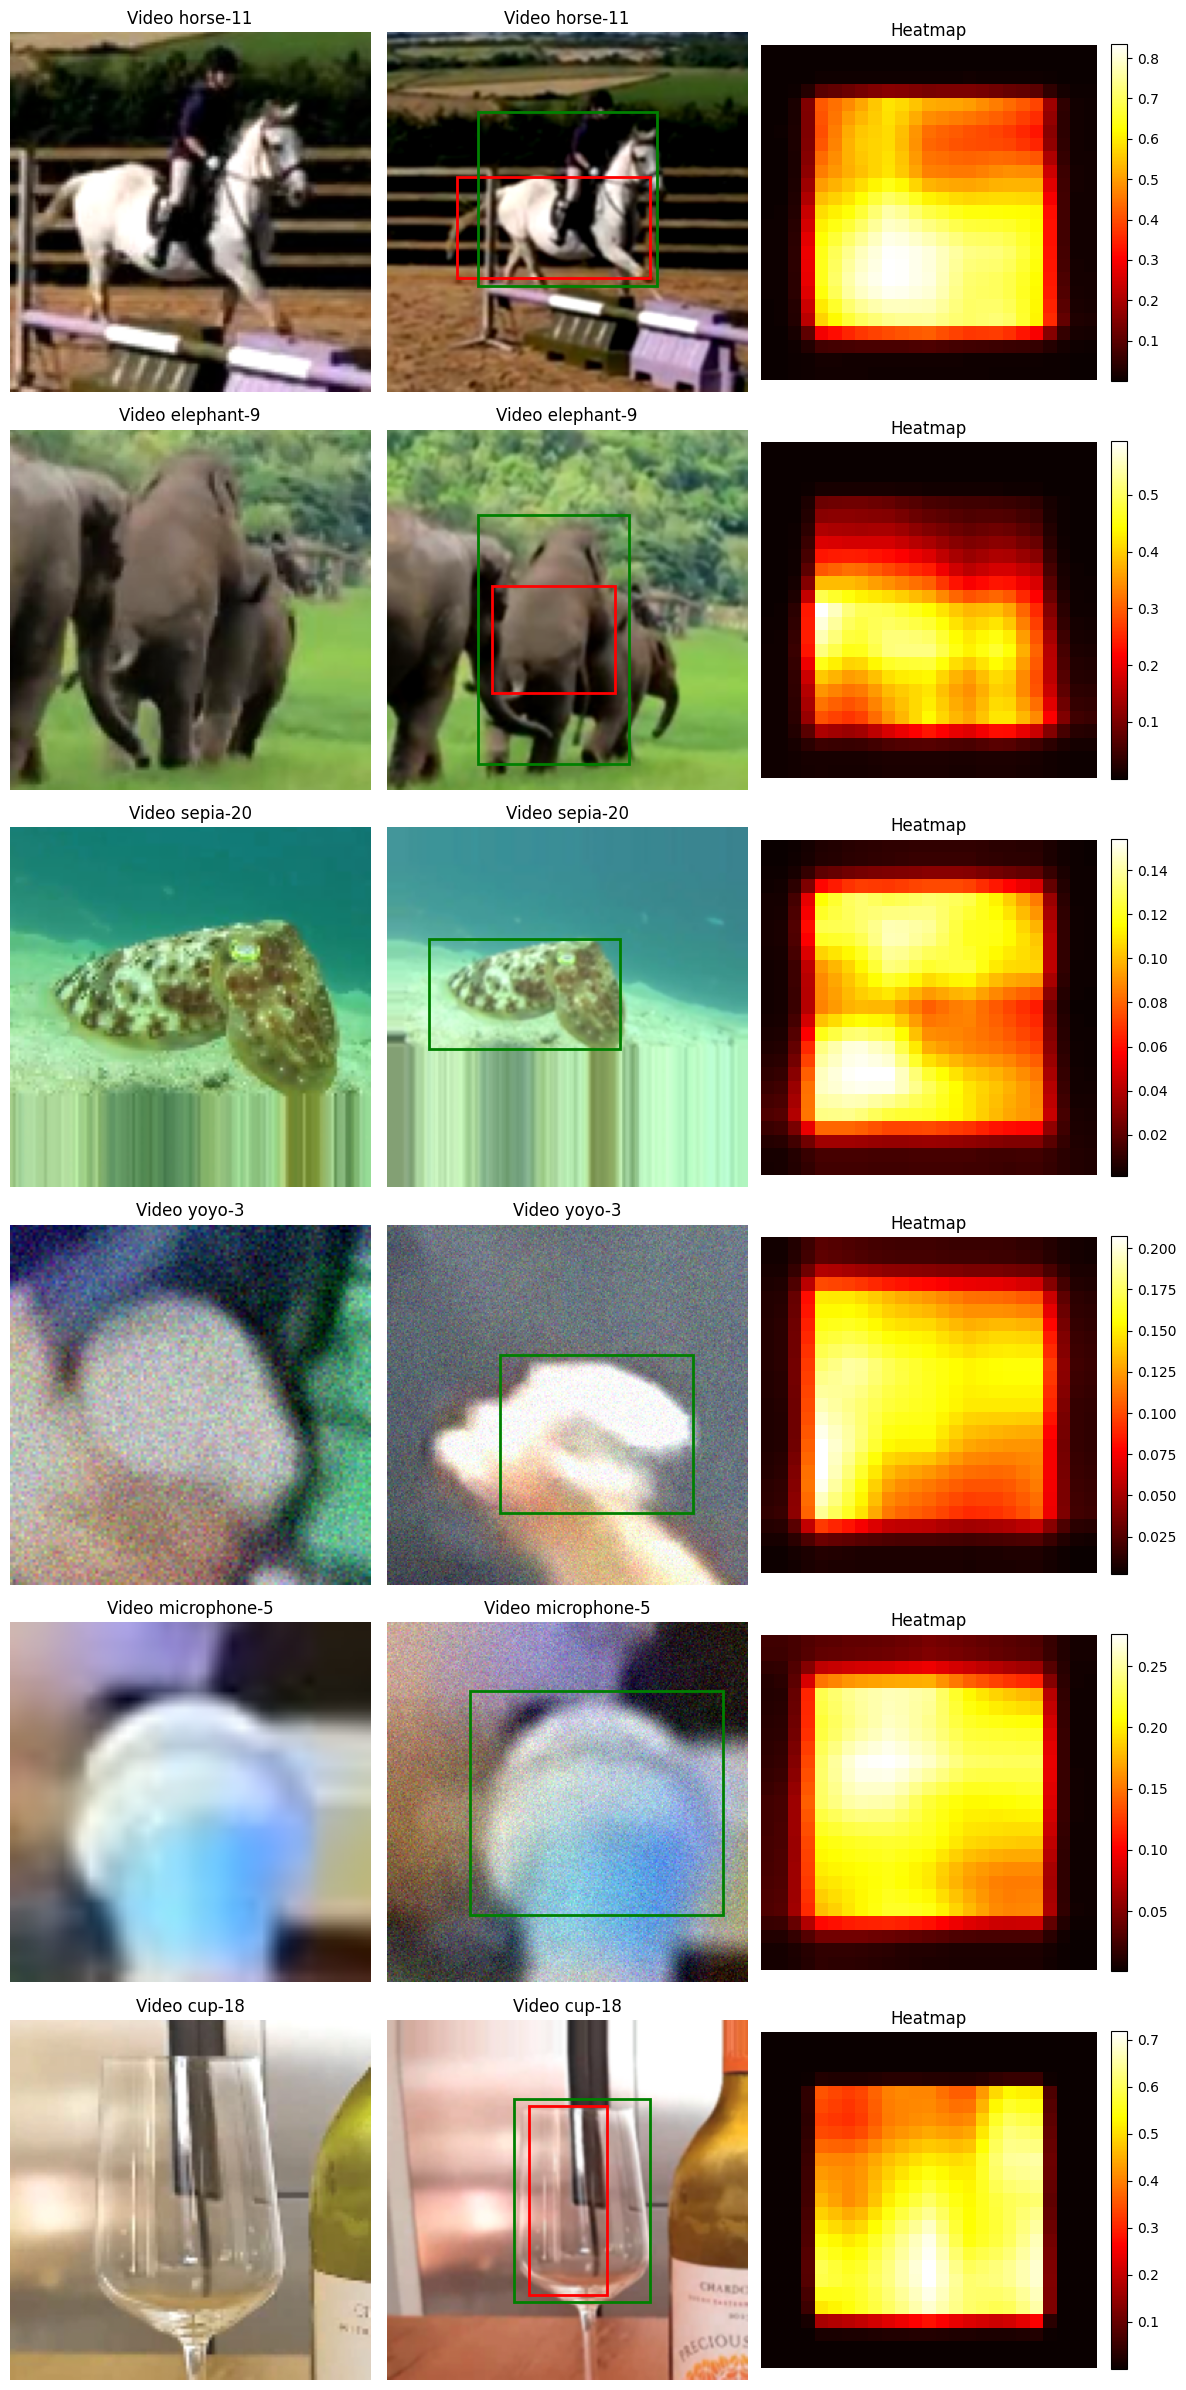

 13%|██████████████████▏                                                                                                                         | 10243/79025 [44:54<5:01:33,  3.80it/s]


KeyboardInterrupt: 

In [3]:
for epoch in range(NUM_EPOCHS):
    ##################### TRAIN #######################
    model.train()
    train_loss = 0.0
    
    for batch_idx, (template, search, heatmap, bbox, video_template_name, video_search_name) in enumerate(tqdm(train_dataloader)):
        template, search, heatmap, bbox = template.to(device, dtype=torch.float), search.to(device, dtype=torch.float), heatmap.to(device, dtype=torch.float), bbox.to(device, dtype=torch.float)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        pred_heatmap, pred_bbox = model(template, search)
        
        # Calculate loss
        loss = compute_loss(pred_heatmap, pred_bbox, heatmap, bbox, ALPHA_LOSS, GAMMA_LOSS, WEIGHT_LOSS)
        
        # Backward pass
        loss[0].backward()
        
        # Gradient clipping and Optimize
        # clip all gradients to max norm 5.0
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        train_loss += loss[0].item()

        if (batch_idx % 1000 == 0 and batch_idx > 0):
            print(f"Epoch {epoch+1}, batch {batch_idx}, Loss: {train_loss/(batch_idx+1)}, cls loss: {loss[1].item()}, regression loss: {loss[2].item()}")

        if (batch_idx % 10000 == 0 and batch_idx > 0):
            draw_samples_training(template, search, torch.sigmoid(pred_heatmap), pred_bbox, heatmap, bbox, train_set.mean, train_set.std, THRESHOLD_CLS, NUM_SAMPLES_PLOT, video_template_name, video_search_name)
    
    train_loss /= float(batch_idx+1)
    
    ##################### VALIDATION #######################
    model.eval()
    val_loss = 0.0
    val_loss_cls = 0.0
    val_loss_reg = 0.0

    with torch.no_grad():
        for batch_idx, (template, search, heatmap, bbox, video_template_name, video_search_name) in enumerate(tqdm(val_dataloader)):
            template, search, heatmap, bbox = template.to(device, dtype=torch.float), search.to(device, dtype=torch.float), heatmap.to(device, dtype=torch.float), bbox.to(device, dtype=torch.float)
    
            # Forward pass
            pred_heatmap, pred_bbox = model(template, search)
            
            # Calculate loss
            loss = compute_loss(pred_heatmap, pred_bbox, heatmap, bbox, ALPHA_LOSS, GAMMA_LOSS, WEIGHT_LOSS)
    
            val_loss += loss[0].item()
            val_loss_cls += loss[1].item()
            val_loss_reg += loss[2].item()
    
            if (batch_idx == 0):
                draw_samples_training(template, search, torch.sigmoid(pred_heatmap), pred_bbox, heatmap, bbox, train_set.mean, train_set.std, THRESHOLD_CLS, NUM_SAMPLES_PLOT, video_template_name, video_search_name)
    
        val_loss /= float(batch_idx+1)
        val_loss_cls /= float(batch_idx+1)
        val_loss_reg /= float(batch_idx+1)
    
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss}, val loss NN total: {val_loss}, val loss CLS: {val_loss_cls},  val loss Reg: {val_loss_reg}")

        if SAVE_MODEL:
            os.makedirs(folder_path, exist_ok=True)
            # Save model and params
            json_params_epoch = json_params.copy()
            json_params_epoch["epoch"] = epoch
            json_params_epoch["train_loss"] = train_loss
            json_params_epoch["val_loss"] = val_loss
            json_params_epoch["val_loss_cls"] = val_loss_cls
            json_params_epoch["val_loss_reg"] = val_loss_reg
            model_path = os.path.join(folder_path,f"model_{epoch}.pth")
            json_path = os.path.join(folder_path,f"params_{epoch}.json")
            torch.save(model.state_dict(), model_path)
            with open(json_path, "w") as outfile:
                json.dump(json_params_epoch, outfile)
    
print("Training finished.")